In [96]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import json
import numpy as np

json_file = 'Data\squat_golden_repetition.json'
# json_file = 'Data\Y-W-golden_repetition.json'

# Load the data
with open(json_file, 'r') as file:
    data = json.load(file)


def preproces_golden_video_metadata(data):
     """Preprocesses golden video metadata by extracting poses with timestamps for visualization."""
    try:
        new_list = []
        for i, frame in enumerate(data['golden_video_metadata']['pose']):
            new_list.append({'timestamp': i, 'pose': frame})

        data = {}
        data['golden_rep_poses'] = new_list
    except:
        pass

    return data

data = preproces_golden_video_metadata(data)

print(data)

{'config': {'iou_threshold': 0.5, 'limb_activity_threshold': 0.25, 'node_axis_threshold': 0.15, 'number_points_displayed': 5}, 'used_nodes': [{'name': 'NOSE', 'index': 0}, {'name': 'LEFT_EYE', 'index': 1}, {'name': 'RIGHT_EYE', 'index': 2}, {'name': 'LEFT_EAR', 'index': 3}, {'name': 'RIGHT_EAR', 'index': 4}, {'name': 'LEFT_SHOULDER', 'index': 5}, {'name': 'RIGHT_SHOULDER', 'index': 6}, {'name': 'LEFT_ELBOW', 'index': 7}, {'name': 'RIGHT_ELBOW', 'index': 8}, {'name': 'LEFT_WRIST', 'index': 9}, {'name': 'RIGHT_WRIST', 'index': 10}, {'name': 'LEFT_HIP', 'index': 11}, {'name': 'RIGHT_HIP', 'index': 12}, {'name': 'LEFT_KNEE', 'index': 13}, {'name': 'RIGHT_KNEE', 'index': 14}, {'name': 'LEFT_FOOT', 'index': 15}, {'name': 'RIGHT_FOOT', 'index': 16}], 'affine_transform_nodes': [{'name': 'NOSE', 'index': 0}, {'name': 'LEFT_HIP', 'index': 11}, {'name': 'RIGHT_HIP', 'index': 12}], 'evaluation_nodes': [{'name': 'NOSE', 'index': 0}], 'golden_rep_poses': [{'timestamp': 0, 'pose': [0.5386903882026672

In [97]:
def get_body_parts(data):
    """
    This function returns 'body_parts' dictionary, that links the name of the body part, with its index.
    """
    try:
        body_parts = {node['name']: node['index'] for node in data['used_nodes']}
    except KeyError:
        # Some exercises (f.e. 'D1_flexion) do not contain the 'used_nodes' key, so let's assume the following:
        body_parts = {
            'NOSE': 0,
            'LEFT_EYE': 1,
            'RIGHT_EYE': 2,
            'LEFT_EAR': 3,
            'RIGHT_EAR': 4,
            'LEFT_SHOULDER': 5,
            'RIGHT_SHOULDER': 6,
            'LEFT_ELBOW': 7,
            'RIGHT_ELBOW': 8,
            'LEFT_WRIST': 9,
            'RIGHT_WRIST': 10,
            'LEFT_HIP': 11,
            'RIGHT_HIP': 12,
            'LEFT_KNEE': 13,
            'RIGHT_KNEE': 14,
            'LEFT_FOOT': 15,
            'RIGHT_FOOT': 16
        }
    return body_parts

def get_list_of_positions(data):
    """
    This function preprocesses the 'golden_rep_poses' key into a list of frames.
    Each frame is a list of tuples (x, y) representing the position of each node.
    """
    list_of_positions = []
    for timestamp in data['golden_rep_poses']:
        positions = timestamp['pose']
        list_of_tuples_for_each_timestamp = [
            [positions[i], positions[i+1]] for i in range(0, 34, 2)
        ]
        list_of_positions.append(list_of_tuples_for_each_timestamp)
    return list_of_positions

def transform_list_of_positions(list_of_positions):
    """the function can be extended, for now I need only to reflect the node by liney=0.5, as the image is
    upside-down
    
    When we will need to add a scale it's a good place to do so.
    
    """
    for frame in list_of_positions:
        for node in frame:
            node[1] = -node[1]+1
            # print(node)

    return list_of_positions


def add_fake_point_between_A_and_B(A, B, list_of_positions, body_parts, name):
    """
    Adds a fake point between points A and B and appends it to each frame in list_of_positions.
    """
    for frame in list_of_positions:
        fake_point_x = (frame[body_parts[A]][0] + frame[body_parts[B]][0]) / 2
        fake_point_y = (frame[body_parts[A]][1] + frame[body_parts[B]][1]) / 2
        frame.append((fake_point_x, fake_point_y))
    body_parts[name] = len(body_parts)

def get_trace(node, list_of_positions, body_parts):
    trace = []
    node_index = body_parts[node]
    for frame in list_of_positions:
        trace.append(frame[node_index])

    return trace

def get_velocity(trace):
    x_vel = []
    y_vel = []
    for frame in trace:
        x_vel.append(frame[0])
        y_vel.append(frame[1])
    
    return np.gradient(np.array(x_vel)), np.gradient(np.array(y_vel))


HUMAN_BLUEPRINT = [
    ('LEFT_SHOULDER', 'LEFT_ELBOW'), ('LEFT_ELBOW', 'LEFT_WRIST'),
    ('RIGHT_SHOULDER', 'RIGHT_ELBOW'), ('RIGHT_ELBOW', 'RIGHT_WRIST'),
    ('RIGHT_SHOULDER', 'LEFT_SHOULDER'), ('RIGHT_HIP', 'LEFT_HIP'),
    ('LEFT_HIP', 'LEFT_KNEE'), ('LEFT_KNEE', 'LEFT_FOOT'),
    ('RIGHT_HIP', 'RIGHT_KNEE'), ('RIGHT_KNEE', 'RIGHT_FOOT')
]


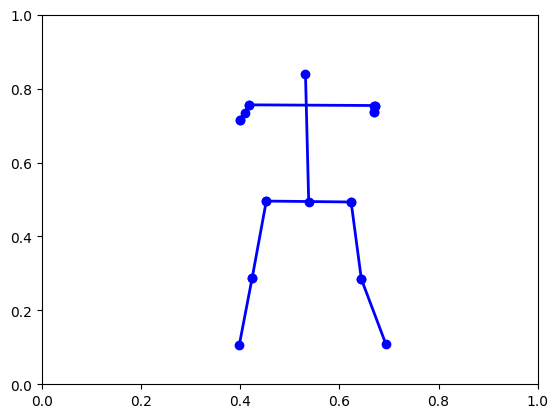

In [98]:
body_parts = get_body_parts(data)
list_of_positions = get_list_of_positions(data)
list_of_positions = transform_list_of_positions(list_of_positions)

# Add fake point between hips to visualise the spine
add_fake_point_between_A_and_B('RIGHT_HIP', 'LEFT_HIP', list_of_positions, body_parts, 'MID_HIP')

# Add the connection from the MID_HIP to the NOSE 
HUMAN_BLUEPRINT.append(('MID_HIP', 'NOSE'))

# Convert HUMAN_BLUEPRINT to indexes
connections = [(body_parts[start], body_parts[end]) for start, end in HUMAN_BLUEPRINT]

trace = get_trace('MID_HIP', list_of_positions, body_parts)
x_vel, y_vel = get_velocity(trace)
# print(x_vel)
velocity = np.sqrt(x_vel**2 + y_vel**2)
# print(velocity)

fig, ax = plt.subplots()
ax.set_xlim(0, 1) 
ax.set_ylim(0, 1) 

lines = [ax.plot([], [], 'bo-', lw=2)[0] for _ in connections]
trace_line, = ax.plot([], [], 'r-', lw=1)
velocity_text = ax.text(0.3, 0.7, '', transform=ax.transAxes, color='black', fontsize=12, verticalalignment='top')



def animate(i):
    """Update the animation with each frame."""
    frame = list_of_positions[i]
    for line, (start, end) in zip(lines, connections):
        x = [frame[start][0], frame[end][0]]
        y = [frame[start][1], frame[end][1]]
        line.set_data(x, y)


    # if i < len(trace):
    #     trace_x = [pos[0] for pos in trace[:i+1]]
    #     trace_y = [pos[1] for pos in trace[:i+1]]
    #     trace_line.set_data(trace_x, trace_y)

    # current_velocity = velocity[i]
    # velocity_text.set_text(f'v={round(current_velocity, 3)}')
    # velocity_text.set_position((trace_x[-1], trace_y[-1]))

    # print(velocity)
    return lines + [trace_line]

    # return lines

# Create animation
ani = FuncAnimation(fig, animate, frames=len(list_of_positions), interval=100, blit=True)

gif_path = 'Animations/'+json_file[5:-5] + '_animation.gif'
ani.save(gif_path, writer=PillowWriter(fps=30))

plt.show()

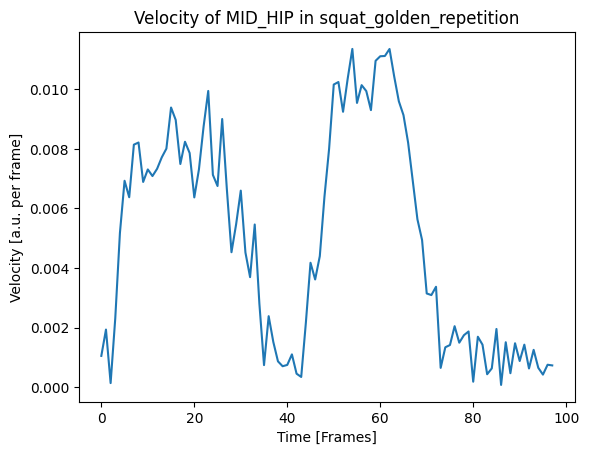

In [100]:
plt.title(f'Velocity of MID_HIP in {json_file[5:-5]}')
plt.plot(velocity)
plt.xlabel('Time [Frames]')
plt.ylabel('Velocity [a.u. per frame]')


plt.savefig(f'Plots/Velocity of MID_HIP in {json_file[5:-5]}.png')